In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd drive/My\ Drive/cronathroat/WithoutRevist_Fullaugumented/

/content/drive/My Drive/cronathroat/WithoutRevist_Fullaugumented


In [4]:
pwd

'/content/drive/My Drive/cronathroat/WithoutRevist_Fullaugumented'

In [0]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import os
import random
from skimage import io, transform
import numpy as np
from skimage.color import rgb2gray
import pandas as pd

In [0]:
trainingData = pd.read_csv("train.csv")

testingData = pd.read_csv("test.csv")


In [0]:
from PIL import Image
def readData(df, path):
    
    imageArray  = [] 
    labelArray = []
        
    for index, row in df.iterrows():
        imageFileName = row['Name']
        label = row['Label']
        labelArray.append(label)

        try:
            img = Image.open(path+imageFileName)
            #img = io.imread(path+imageFileName, plugin='matplotlib')
            #img = rgb2gray(img)
            #img = img.convert('RGB')
            img = transform.resize(np.array(img), (224, 224),anti_aliasing=True)#height,width
            #io.imshow(img) 
            #io.show()
            #return
            #img = img.reshape(img.shape[0],img.shape[1],1)
            imageArray.append(img)
            #Normalizing image data
            
        
        except Exception as e:
            print(e)
            pass
    return imageArray, labelArray

In [0]:
train_X, train_Y = readData(trainingData, "./train/")

In [0]:
test_X, test_Y = readData(testingData, "./test/")

In [0]:
train_X[0].shape

(224, 224, 3)

In [0]:
learningRate = 0.001
dropOut = 0.1

height = 224
width = 224
num_classes = 1

In [15]:
tf.compat.v1.disable_eager_execution()

tf.compat.v1.reset_default_graph()



inputImage = tf.compat.v1.placeholder(tf.float32, shape=[None, height, width,3], name="X")
#label = tf.compat.v1.placeholder(tf.float32, shape=[None], name="label")
label = tf.compat.v1.placeholder(tf.float32, shape=[None], name="label")
l_rate = tf.compat.v1.placeholder(tf.float32, name = "learningRate")
d_out = tf.compat.v1.placeholder(tf.float32, name = "dropOut")


regularizer = tf.keras.regularizers.l2()

conv2d_1 = tf.compat.v1.layers.conv2d(inputImage, 
                               filters=4, 
                               kernel_size=[3,3],
                               strides=[1,1], 
                               padding='SAME', 
                               activation="tanh",
                               kernel_regularizer = regularizer,
                               name="conv2d_1")
conv2d_1_dropout = tf.nn.dropout(conv2d_1, rate=d_out)

conv2d_2 = tf.compat.v1.layers.conv2d(conv2d_1_dropout, 
                               filters=6, 
                               kernel_size=[3,3],
                               strides=[1,1], 
                               padding='SAME', 
                               activation="tanh",
                               kernel_regularizer = regularizer,
                               name="conv2d_2")
conv2d_2_dropout = tf.nn.dropout(conv2d_2, rate=d_out*2)

conv2d_3 = tf.compat.v1.layers.conv2d(conv2d_2_dropout, 
                               filters=8, 
                               kernel_size=[3,3],
                               strides=[1,1], 
                               padding='SAME', 
                               activation="tanh",
                               kernel_regularizer = regularizer,
                               name="conv2d_3")
conv2d_3_dropout = tf.nn.dropout(conv2d_3, rate=d_out*2)



flat_layer = tf.reshape(conv2d_3, shape=
                        [-1, conv2d_3.shape[1]*conv2d_3.shape[2]*conv2d_3.shape[3]])
fc1 = tf.compat.v1.layers.dense(flat_layer, 32, activation=tf.nn.relu, 
                                kernel_regularizer = regularizer,
                                name="fc1")
fc1_dropout = tf.nn.dropout(fc1, rate=d_out*2)

fc2 = tf.compat.v1.layers.dense(fc1_dropout, 16, activation=tf.nn.relu, 
                                kernel_regularizer = regularizer,
                                name="fc2")
fc2_dropout = tf.nn.dropout(fc2, rate=d_out)


logit = tf.compat.v1.layers.dense(fc2_dropout,num_classes , 
                                   kernel_regularizer = regularizer,
                                   name="logit")

'''
#Adding Regularization loss
vars   = tf.compat.v1.trainable_variables()
lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in vars
                    if 'bias' not in v.name ]) * 0.001

softmax = tf.nn.softmax(logits = logit)

xentropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=label, logits=logit)

loss = tf.reduce_mean(tf.math.square(xentropy))

losses = tf.math.add(loss,lossL2)

total_loss = tf.identity(losses, name="totalLoss")

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=l_rate)
training_op = optimizer.minimize(total_loss)


# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logit, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.compat.v1.global_variables_initializer()
'''



sigmoidal_ouput = tf.math.sigmoid(logit)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(label, tf.reshape(logit, shape=[-1]))

#Adding Regularization loss
vars   = tf.compat.v1.trainable_variables()
r_loss = tf.add_n([tf.nn.l2_loss(v) for v in vars
                    if 'bias' not in v.name ]) * 0.01

loss = tf.reduce_mean(xentropy)
losses = tf.math.add(loss,r_loss)

total_loss = tf.identity(losses, name="totalLoss")
optimizer = tf.compat.v1.train.AdamOptimizer(l_rate)
training_op = optimizer.minimize(total_loss)

init = tf.compat.v1.global_variables_initializer()


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.Dense instead.


In [0]:
def binaryConvertor(arr):
    binaryArray = []
    for (index,val) in enumerate(arr):
        if(arr[index]>=0.5):
            binaryArray.append(1)
        else:
            binaryArray.append(0)
    return np.asarray(binaryArray)

In [0]:
print(logit,"\n","\n",total_loss, "\n", label, "\n", d_out, "\n",xentropy, "\n","\n","\n")

Tensor("logit/BiasAdd:0", shape=(None, 1), dtype=float32) 
 
 Tensor("totalLoss:0", shape=(), dtype=float32) 
 Tensor("label:0", shape=(None,), dtype=float32) 
 Tensor("dropOut:0", dtype=float32) 
 Tensor("logistic_loss:0", shape=(None,), dtype=float32) 
 
 



In [0]:
def get_batchofImage(X, y, bsize):
    for batch_i in range(0, 1 + (len(X) //bsize)):
        start_i = batch_i * bsize
        try:
            X_data = X[start_i:start_i + bsize]    
            y_data = y[start_i:start_i + bsize]      
        except IndexError:
            X_data = X[start_i:]
            y_data = y[start_i:]
        yield np.array(X_data), np.array(y_data)

In [0]:
n_epochs = 50
trainingLoss = []
testloss = []

with tf.compat.v1.Session() as sess:
    init.run()
    saver = tf.compat.v1.train.Saver()
    for epoch in range(n_epochs):
        i = 0
        cost = 0 
        for index,(data,labels) in enumerate(get_batchofImage(train_X,train_Y,45)):
            #print(data.shape, labels.shape)
            if(len(data) == 0):
                continue
            l, prediction,_ = sess.run(( total_loss,sigmoidal_ouput, training_op), feed_dict={inputImage: data, label: labels, 
                                             l_rate:learningRate,d_out:dropOut
                                             })
            cost = cost+l
            
        cost = cost/index
        trainingLoss.append(np.round(cost,6))
        print("training loss:........",np.round(cost,6))
        if(epoch%10==0):
          print("loss:  ", np.round(cost,6))
          binary = binaryConvertor(prediction)
          print("\n\n\nTraining: labels:",np.column_stack((labels,  np.round(prediction,6), binary)))
        oldArray = []
        for index,(data,labels) in enumerate(get_batchofImage(test_X,test_Y,90)):

            l, out = sess.run((total_loss, sigmoidal_ouput), feed_dict={inputImage: data, label: labels, 
                                              l_rate:learningRate, d_out:0.0
                                              })
            pred = binaryConvertor(out)
            testloss.append(np.round(l,6))
            #oldArray = np.column_stack((oldArray, out))
            print("test loss:*************************",np.round(l,6))
            #print("\n\n\Testing:",np.column_stack((labels, np.round(out,6), pred)))
            break
            # print(val.shape)
           
        #acc_train = accuracy.eval(feed_dict={X: X_bach, y: y_batch})
        #acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        if(epoch%20==0):
          print("\n\n\Testing:",np.column_stack((labels, np.round(out,6), pred)))
            
          #print( "testloss:", testloss, sess, saver)

    try:
      save_path = saver.save(sess, "./throat/trained")
      print("saved")
    except Exception as e:
      print(e)

training loss:........ 3.615222
loss:   3.615222



Training: labels: [[1.         0.49886    0.        ]
 [1.         0.49886    0.        ]
 [1.         0.498606   0.        ]
 [1.         0.76921701 1.        ]
 [0.         0.498606   0.        ]
 [1.         0.79854703 1.        ]
 [1.         0.49886    0.        ]
 [1.         0.49975201 0.        ]
 [1.         0.49886    0.        ]
 [0.         0.49910399 0.        ]
 [0.         0.499762   0.        ]
 [0.         0.49905699 0.        ]
 [1.         0.49877101 0.        ]
 [0.         0.49910399 0.        ]
 [1.         0.61546999 1.        ]
 [1.         0.49886    0.        ]
 [0.         0.49886    0.        ]
 [1.         0.49886    0.        ]
 [0.         0.62589902 1.        ]
 [0.         0.49514899 0.        ]
 [1.         0.49886    0.        ]
 [0.         0.65490299 1.        ]
 [1.         0.49886    0.        ]
 [0.         0.49886    0.        ]
 [1.         0.49886    0.        ]
 [0.         0.49886    0.    

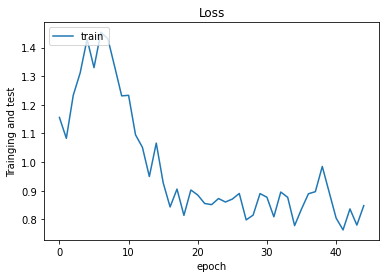

In [0]:
from matplotlib import pyplot as plt
plt.plot(trainingLoss[5:])
#plt.plot(testloss)
plt.title('Loss')
plt.ylabel('Trainging and test') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

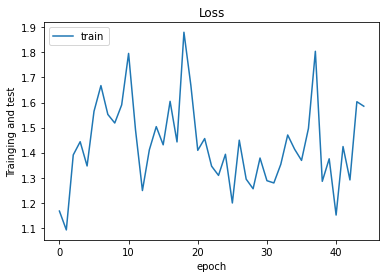

In [0]:
from matplotlib import pyplot as plt
#plt.plot(trainingLoss)
plt.plot(testloss[5:])
plt.title('Loss')
plt.ylabel('Trainging and test') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
losses =[]
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
   
with tf.compat.v1.Session() as sess:
  # Restore variables from disk.
  saver = tf.compat.v1.train.import_meta_graph('{0}.meta'.format( "./throat/trained"))       
  saver.restore(sess, "./throat/trained")
  print("*******************************Model restored.")
  inputImage = tf.compat.v1.get_default_graph().get_tensor_by_name('X:0')
  label =       tf.compat.v1.get_default_graph().get_tensor_by_name('label:0')
  sigmoidal_ouput =       tf.compat.v1.get_default_graph().get_tensor_by_name('Sigmoid:0')
  
  totalLoss =  tf.compat.v1.get_default_graph().get_tensor_by_name('totalLoss:0')
  d_out =  tf.compat.v1.get_default_graph().get_tensor_by_name("dropOut:0")
  #pred =  tf.compat.v1.get_default_graph().get_tensor_by_name("Equal:0")
  #acc =  tf.compat.v1.get_default_graph().get_tensor_by_name("Mean_1:0")
  logit =  tf.compat.v1.get_default_graph().get_tensor_by_name('logit/BiasAdd:0')
 

  

  for index,(data,labels) in enumerate(get_batchofImage(test_X,test_Y,200)):

          l, out = sess.run((totalLoss, sigmoidal_ouput), feed_dict={inputImage: data, label: labels, d_out:0.0
                                            })
          pred = binaryConvertor(out)
          #losses.append(np.round(l,6))
          #oldArray = np.column_stack((oldArray, out))
          #print("\n\n\Testing:",l, "\n",np.column_stack((labels, np.round(out,6), pred)))
          print(confusion_matrix(labels,pred))
          print(recall_score(labels,pred))
          break

INFO:tensorflow:Restoring parameters from ./throat/trained
*******************************Model restored.
[[11  2]
 [ 8  9]]
0.5294117647058824


In [18]:
pip install tensornets


     |████████████████████████████████| 655kB 2.8MB/s 
  Installing build dependencies ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for tensornets: filename=tensornets-0.4.6-cp36-cp36m-linux_x86_64.whl size=1222191 sha256=bbd4c92cf1272aa2fa49db5a69c134b71fd6a54f7f161275b73d6f73e4a408cd
  Stored in directory: /root/.cache/pip/wheels/89/18/ea/82c6d494fb3ae5e080cd34bd3cff9f92ddbf3292fcfa9e3ce5
Successfully built tensornets


In [0]:
import tensorflow as tf
import tensornets as nets

In [0]:
learningRate = 0.005
dropOut = 0.10

In [0]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

x = tf.compat.v1.placeholder(tf.float32, shape=(None, 224, 224, 3), name='input_x')
y = tf.compat.v1.placeholder(tf.float32, shape=(None), name='output_y')
l_rate = tf.compat.v1.placeholder(tf.float32, name="rate")

regularizer = tf.keras.regularizers.l2()
vgg19 = nets.VGG19(x, is_training=True, classes=20)
model = tf.identity(vgg19, name='logits')
lastFC = tf.compat.v1.get_default_graph().get_tensor_by_name('vgg19/drop7/dropout/Mul_1:0')




fc1 = tf.compat.v1.layers.dense(lastFC, 64, 
                                   kernel_regularizer = regularizer,
                                   activation = tf.nn.leaky_relu,
                                   name="fc1")

logit = tf.compat.v1.layers.dense(fc1, 1, 
                                   kernel_regularizer = regularizer,
                                   name="fc2")

sigmoidal_ouput = tf.math.sigmoid(logit, name = 'sig_output')
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = tf.reshape(logit, shape=[-1]))



vars   = tf.compat.v1.trainable_variables()
lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in vars
                    if 'bias' not in v.name ]) * 0.005

loss = tf.reduce_mean(xentropy)
total_loss = tf.math.add(loss,lossL2, name="sum")

losses = tf.identity(total_loss, "accumulated_loss")

optimizer = tf.compat.v1.train.AdamOptimizer(l_rate)
training_op = optimizer.minimize(losses)


In [0]:
def get_batch(arr, label, bsize):
    for batch_i in range(0, 1 + (len(arr) //bsize)):
        start_i = batch_i * bsize
        try:
            X = arr[start_i:start_i + bsize]  
            y = label[start_i:start_i + bsize]  
        except IndexError:
            X = arr[start_i:]
            y = label[start_i:]
        #print(X.shape, y.shape)
        yield X,y

In [0]:
def binaryConvertor(arr):
    binaryArray = []
    for (index,val) in enumerate(arr):
        if(arr[index]>=0.5):
            binaryArray.append(1)
        else:
            binaryArray.append(0)
    return np.asarray(binaryArray)

In [0]:
epochs = 20
trainingLoss = []
testloss = []

print('Training...')
with tf.compat.v1.Session() as sess:    
    # Initializing the variables
    sess.run(tf.compat.v1.global_variables_initializer())


    saver = tf.compat.v1.train.Saver()
    #saver.restore(sess, tf.train.latest_checkpoint('./transferLearning/'))
    
    
    
    print('global_variables_initializer ... done ...')
    sess.run(vgg19.pretrained())

    for epoch in range(epochs):
        i = 0
        cost = 0 
        for index,(data,labels) in enumerate(get_batch(train_X,train_Y,35)):
            if(len(data) == 0):
                continue
            l, prediction,_ = sess.run((losses, sigmoidal_ouput, training_op), feed_dict={x: data,
                                                                                          y: labels,
                                                                                          l_rate:learningRate})
            
            cost = cost+l
            
        cost = cost/index
        trainingLoss.append(np.round(cost,6))

        print("Training loss:  ", np.round(cost,6))
        binary = binaryConvertor(prediction)
        print("\n\n\nTraining: labels:",np.column_stack((labels,  np.round(prediction,6), binary)))
        oldArray = []
        for index,(data,labels) in enumerate(get_batch(test_X,test_Y,90)):

            l, out = sess.run((losses, sigmoidal_ouput), feed_dict={x: data, y: labels, 
                                              l_rate:learningRate})
            pred = binaryConvertor(out)
            testloss.append(np.round(l,6))
            #oldArray = np.column_stack((oldArray, out))
            print("\n\n\Testing:",np.column_stack((labels, np.round(out,6), pred)))
            break
            # print(val.shape)
           
    
    
    
    
    # Save Model
    print("saving model")
    
    save_path = saver.save(sess, './transferLearning/model')

Training...
global_variables_initializer ... done ...
574717952/574710816 [==============================] - 6s 0us/step
Training loss:   80048145742.72206



Training: labels: [[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]


\Testing: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Training loss:   3149.2094



Training: labels: [[0.         1.         1.        ]
 [1. 

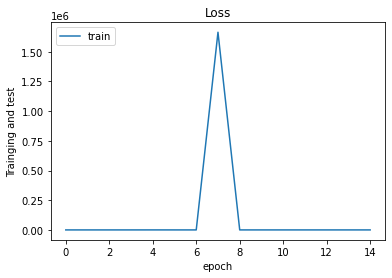

In [0]:
from matplotlib import pyplot as plt
plt.plot(trainingLoss[5:])
#plt.plot(testloss)
plt.title('Loss')
plt.ylabel('Trainging and test') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

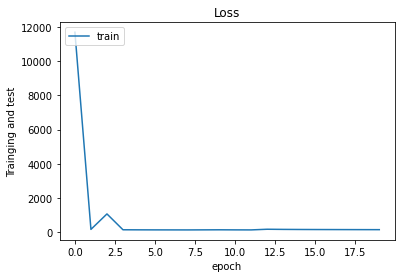

In [0]:
from matplotlib import pyplot as plt
#plt.plot(trainingLoss[5:])
plt.plot(testloss)
plt.title('Loss')
plt.ylabel('Trainging and test') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()